In [1]:
import numpy as np
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.special import gamma
import random

In [2]:
# Get mean and variance for Chi distribution of N degrees of freedom.
class chidist():
    def __init__(self,dof):
        self.dof = dof
        self.mean = None
        self.var = None
        
    def get_mean(self):
        self.mean = np.sqrt(2)*gamma((self.dof+1)/2)/gamma(self.dof/2)
        return self.mean
        
    def get_var(self):
        self.get_mean()
        self.var = self.dof-self.mean**2
        return self.var

### Build toy problem:

In [107]:
# Objective function construction (negative Gaussian)
nz = 2
chi = chidist(nz)
mchi = chi.get_mean()
vchi = chi.get_var()
sig = 0.05
covmat = sig*torch.eye(nz)
invcovmat = (1/sig)*torch.eye(nz)
sig4 = 2.0
covmat4 = sig4*torch.eye(nz)
invcovmat4 = (1/sig4)*torch.eye(nz)
mu = torch.ones(nz)*torch.tensor([1.5,0.9])
mu2 = torch.ones(nz)*torch.tensor([1.1,1.3])
mu3 = torch.ones(nz)*torch.tensor([1.0,0.4])
c1,c2,c3,c4 = -0.7,-0.5,-0.5,-40.0

mu4 = torch.ones(nz)*torch.tensor([1.5,1.0])

In [108]:
# Initialize with multivariate normal
zinit = 1.0*np.random.randn(nz)

# Initialize in "ring"
#zdir = 1.0*np.random.randn(nz)
#zdir = zdir/np.linalg.norm(zdir)
#zinit = (np.sqrt(vchi)*np.random.randn()+mchi)*zdir

# Initialize in specific value
#zinit = np.array([1.4,1.4])

In [109]:
# set initial model in torch:
z = 1.0*torch.randn(nz)
z.data = torch.Tensor(zinit)
z.requires_grad = True

In [110]:
# Optimization parameters
data_cost = []
zs = []
lam = 1e-3
alpha = 2*vchi # clipping ring radius
chi_mean = mchi
maxiter = 1000
lr = 0.4 # for decreasing SGD
#lr = 0.1 # for Adam
grad_noise = 1e0
#optimizer = optim.Adam([z], lr=lr, betas=(0.9,0.999))
optimizer = optim.SGD([z], lr=lr)#, momentum=0.5)

In [111]:
def multinormal(z,mu,invcovmat):
    nz = z.numel()
    f = (2*np.pi)**(-nz/2)*torch.det(invcovmat)**(1/2)*torch.exp(-0.5*torch.dot((z-mu),torch.mv(invcovmat,(z-mu))))
    return f

def quadratic(z,c,A):
    nz = z.numel()
    z_tras = z-c
    f = torch.matmul(torch.matmul(torch.matmul(z_tras.T,A.T),A),z_tras)
    return f

def quadratic_np(z,c,A):
    f = np.zeros(z.shape[0])
    for i in range(z.shape[0]):
        z_tras = z[i,:]-c
        f[i] = z_tras.T@A.T@A@z_tras
    return f

In [112]:
cost = 0
for it in range(maxiter):
    # stochastic clipping if ||z|| is outside "ring"
    #while ((torch.norm(z)>(chi_mean+alpha))|(torch.norm(z)<(chi_mean-alpha))):
    #    z.data = (random.normalvariate(chi_mean,alpha/2))*(z.data/torch.norm(z))
    #    print('jump!!')
    
    data_loss = c1*multinormal(z,mu,invcovmat)+c2*multinormal(z,mu2,invcovmat)+c3*multinormal(z,mu3,invcovmat)+c4*multinormal(z,mu4,invcovmat4)
    #data_loss = c1*multinormal(z,mu,invcovmat)+c2*multinormal(z,mu2,invcovmat)+c3*multinormal(z,mu3,invcovmat)+quadratic(z,mu4,A1)
    reg_loss = lam*(torch.norm(z)-np.sqrt(mchi))**2 #lam*torch.sum(z**2)
    cost = data_loss + reg_loss
    
    if it==0: cost_min = cost

    if cost<=cost_min:
        cost_min = cost
        zmin = np.copy(z.data.cpu().numpy())
        itdum = it

    data_cost.append(data_loss.detach().numpy())
    zs.append(np.copy(z.data.cpu().numpy()))
    
    print(it,data_cost[-1])
    
    optimizer.zero_grad()
    cost.backward()
    #optimizer.step() # for Adam
    # for SGD:
    z.data = z.data-lr*(z.grad.data+grad_noise*torch.randn(nz))
    z.grad.data.zero_()
    if (it%5)==0:
        lr = lr*0.98
        lam = lam*0.95

0 -1.2335596
1 -3.038674
2 -3.2128603
3 -4.407195
4 -0.630048
5 -1.451454
6 -2.5313952
7 -2.8446386
8 -4.040741
9 -1.0269415
10 -1.5601513
11 -3.7167828
12 -1.875124
13 -2.037234
14 -3.2466452
15 -4.492159
16 -2.2407768
17 -3.9851027
18 -2.245512
19 -3.3663616
20 -2.2957535
21 -2.637176
22 -3.2780075
23 -3.8887975
24 -1.4186628
25 -1.4278749
26 -1.5178058
27 -3.3280978
28 -2.041192
29 -2.5162926
30 -3.3370693
31 -3.2557569
32 -1.241311
33 -1.6687456
34 -1.7439985
35 -2.4623756
36 -4.206527
37 -2.102075
38 -1.894228
39 -2.812936
40 -3.2809782
41 -3.6344624
42 -2.0291286
43 -2.466499
44 -4.419591
45 -1.6570001
46 -1.7957841
47 -2.1464791
48 -2.923405
49 -3.835349
50 -2.084397
51 -2.9803877
52 -3.7952447
53 -1.7453864
54 -3.0478687
55 -5.3042383
56 -2.4886675
57 -3.9939628
58 -2.8892274
59 -2.8209403
60 -3.4855206
61 -2.758417
62 -3.9071975
63 -2.3386323
64 -2.5747924
65 -3.1399567
66 -3.68877
67 -2.8183024
68 -2.8529773
69 -3.4249108
70 -4.241133
71 -1.7951583
72 -2.1091123
73 -4.4537573

594 -5.473527
595 -5.424369
596 -5.4543138
597 -5.4801173
598 -5.308522
599 -5.437904
600 -5.4684887
601 -5.466066
602 -5.4415646
603 -5.4715033
604 -5.471938
605 -5.468062
606 -5.4637938
607 -5.4642196
608 -5.477583
609 -5.4612846
610 -5.331422
611 -5.4539423
612 -5.479617
613 -5.477088
614 -5.4556484
615 -5.481303
616 -5.438429
617 -5.485531
618 -5.393018
619 -5.455064
620 -5.473456
621 -5.405265
622 -5.441058
623 -5.4817886
624 -5.3921304
625 -5.421998
626 -5.480358
627 -5.450896
628 -5.4601297
629 -5.3678865
630 -5.4396515
631 -5.4714656
632 -5.4803333
633 -5.4347067
634 -5.4520454
635 -5.476941
636 -5.4290695
637 -5.342584
638 -5.3523254
639 -5.455228
640 -5.4462757
641 -5.4815903
642 -5.4847393
643 -5.444354
644 -5.439294
645 -5.4527426
646 -5.463296
647 -5.3326225
648 -5.4742374
649 -5.4554596
650 -5.4773273
651 -5.4779835
652 -5.437269
653 -5.462693
654 -5.4697733
655 -5.369708
656 -5.46856
657 -5.431141
658 -5.432264
659 -5.4843736
660 -5.38165
661 -5.463993
662 -5.411326
663 

### Inversion results:

min cost: -5.488055229187012
z of min cost: [1.48499    0.91655415]
min for iteration #: 975
true min cost: -3.1830988144060393
true z: tensor([1.5000, 0.9000])
finals lambda:0.00000, lr:0.00704


Text(0.5, 0, 'iteration #')

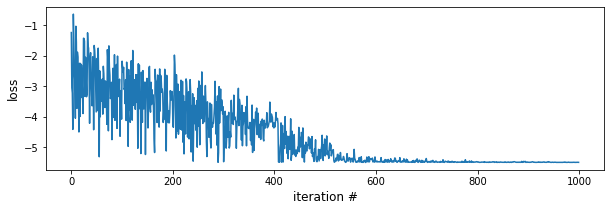

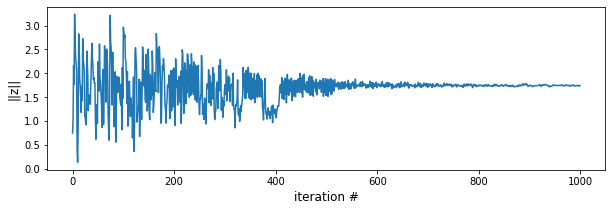

In [113]:
print('min cost: {0}'.format(cost_min))
print('z of min cost: {0}'.format(zmin))
print('min for iteration #: {0}'.format(itdum))
print('true min cost: {0}'.format(-multivariate_normal.pdf(mu,mu,covmat)))
print('true z: {0}'.format(mu))
print('finals lambda:{0:.5f}, lr:{1:.5f}'.format(lam,lr))

fig,ax = plt.subplots(figsize=(10,3))
ax.plot(data_cost)
ax.set_ylabel('loss',fontsize=12)
ax.set_xlabel('iteration #',fontsize=12)

znorms = np.zeros(len(zs))
for i,lz in enumerate(zs):
    znorms[i] = np.linalg.norm(lz)
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(znorms)
ax.set_ylabel('||z||',fontsize=12)
ax.set_xlabel('iteration #',fontsize=12)

In [114]:
x = np.linspace(-3,3,100)
X,Y = np.meshgrid(x,x)
coords = np.column_stack((X.flatten(),Y.flatten()))
s = 7.0+c1*multivariate_normal.pdf(coords,np.array(mu),np.array(covmat))+c2*multivariate_normal.pdf(coords,np.array(mu2),np.array(covmat)) \
    +c3*multivariate_normal.pdf(coords,np.array(mu3),np.array(covmat))+c4*multivariate_normal.pdf(coords,np.array(mu4),np.array(covmat4))
S = s.reshape(X.shape)

Text(0.5, 0, '$z_1$')

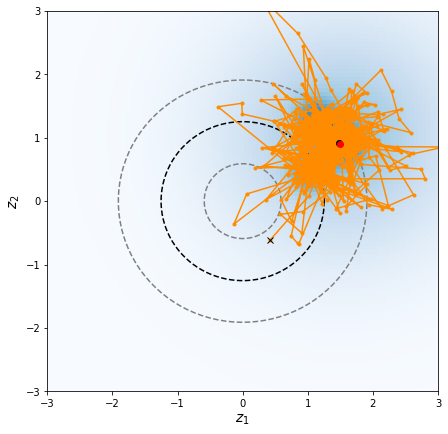

In [116]:
an = np.linspace(0, 2 * np.pi, 100)
outlim = 1.91 # 84 percentile for chi distribution
#outlim = chi_mean+alpha
inlim = 0.59 # 16 percentile
#inlim = chi_mean-alpha

pos = np.array([[1.485,0.913]])

zopt = np.zeros((maxiter,2))
for i in range(maxiter):
    zopt[i] = zs[i]
    
fig,ax = plt.subplots(figsize=(7,7))
ax.pcolor(X,Y,np.log(S),cmap='Blues_r')
ax.plot(outlim * np.cos(an), outlim * np.sin(an),c='gray',linestyle='--')
ax.plot(inlim * np.cos(an), inlim * np.sin(an),c='gray',linestyle='--')
ax.plot(chi_mean * np.cos(an), chi_mean * np.sin(an),c='k',linestyle='--')
ax.plot(zopt[:,0],zopt[:,1],c='darkorange',linestyle='-',marker='.')
ax.plot(pos[0,0],pos[0,1],'ko')
#ax.plot(mu[0],mu[1],'ko')
#ax.plot(zmin[0],zmin[1],'co')
ax.plot(zinit[0],zinit[1],'kx') # initial point
ax.plot(zopt[-1,0],zopt[-1,1],'ro')
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
ax.set_ylabel(r'$z_2$',fontsize=14)
ax.set_xlabel(r'$z_1$',fontsize=14)

Text(0.5, 0, 'loss')

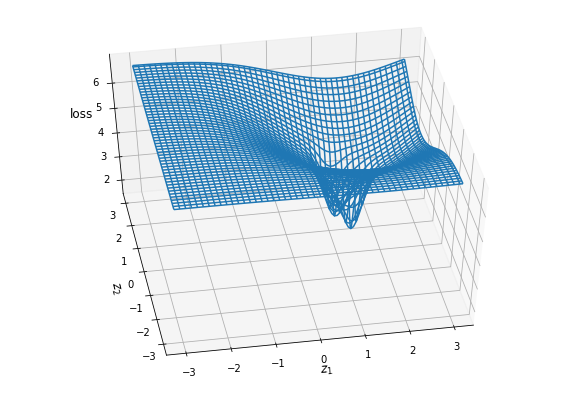

In [117]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X,Y,S)
ax.view_init(50, -100)
ax.set_xlabel(r'$z_1$', fontsize=12)
ax.set_ylabel(r'$z_2$', fontsize=12)
ax.set_zlabel('loss', fontsize=12)

In [118]:
# approximate global minimum position.
s_pos = c1*multivariate_normal.pdf(pos,np.array(mu),np.array(covmat))+c2*multivariate_normal.pdf(pos,np.array(mu2),np.array(covmat)) \
        +c3*multivariate_normal.pdf(pos,np.array(mu3),np.array(covmat))+c4*multivariate_normal.pdf(pos,np.array(mu4),np.array(covmat4))
print(s_pos)
pos = torch.tensor(pos.flatten(),dtype=torch.float32)
data_loss_pos = c1*multinormal(pos,mu,invcovmat)+c2*multinormal(pos,mu2,invcovmat)+c3*multinormal(pos,mu3,invcovmat)+c4*multinormal(pos,mu4,invcovmat4)
print(data_loss_pos)                                                                                                                        

-5.488051668835663
tensor(-5.4881)


Text(0.0, 1.0, 'e)')

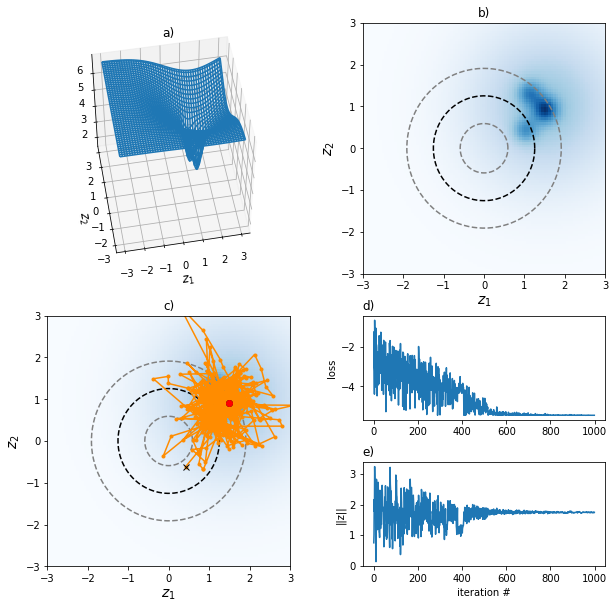

In [119]:
# joint subplot
grid = plt.GridSpec(4, 2, wspace=0.3, hspace=0.4)

fig = plt.figure(figsize=(10,10))

# first:
ax = fig.add_subplot(grid[0:2,0], projection='3d')
ax.plot_wireframe(X,Y,S)
ax.view_init(50, -100)
ax.set_xlabel(r'$z_1$', fontsize=12)
ax.set_ylabel(r'$z_2$', fontsize=12)
#ax.set_zlabel('loss', fontsize=12)
ax.set_title('a)')

# second:
ax = fig.add_subplot(grid[0:2,1])
ax.pcolor(X,Y,np.log(S),cmap='Blues_r')
ax.plot(outlim * np.cos(an), outlim * np.sin(an),c='gray',linestyle='--')
ax.plot(inlim * np.cos(an), inlim * np.sin(an),c='gray',linestyle='--')
ax.plot(chi_mean * np.cos(an), chi_mean * np.sin(an),c='k',linestyle='--')
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
ax.set_ylabel(r'$z_2$',fontsize=14)
ax.set_xlabel(r'$z_1$',fontsize=14)
ax.set_title('b)')

# third:
ax = fig.add_subplot(grid[2:,0])
ax.pcolor(X,Y,np.log(S),cmap='Blues_r')
ax.plot(outlim * np.cos(an), outlim * np.sin(an),c='gray',linestyle='--')
ax.plot(inlim * np.cos(an), inlim * np.sin(an),c='gray',linestyle='--')
ax.plot(chi_mean * np.cos(an), chi_mean * np.sin(an),c='k',linestyle='--')
ax.plot(zopt[:,0],zopt[:,1],c='darkorange',linestyle='-',marker='.')
ax.plot(mu[0],mu[1],'ko')
#ax.plot(zmin[0],zmin[1],'co')
ax.plot(zinit[0],zinit[1],'kx') # initial point
ax.plot(zopt[-1,0],zopt[-1,1],'ro')
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
ax.set_ylabel(r'$z_2$',fontsize=14)
ax.set_xlabel(r'$z_1$',fontsize=14)
ax.set_title('c)')

# fourth:
ax = fig.add_subplot(grid[2:3,1])
ax.plot(data_cost)
ax.set_ylabel('loss')
#ax.set_xlabel('iteration #')
ax.set_title('d)',loc='left')

# fifth
ax = fig.add_subplot(grid[3:,1])
ax.plot(znorms)
ax.set_ylabel('||z||')
ax.set_xlabel('iteration #')
ax.set_title('e)',loc='left')

In [120]:
#fig.savefig("toy_problem_sgd_full.pdf", dpi=150)

Text(0.0, 1.0, 'd)')

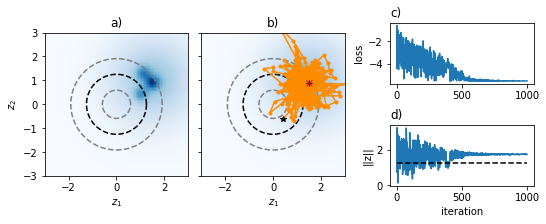

In [131]:
# joint subplot
#grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.4)
#fig = plt.figure(figsize=(10,10))

fig = plt.figure(figsize=(7.48,3), constrained_layout=True)
grid = fig.add_gridspec(2,3)

# first:
ax = fig.add_subplot(grid[:,0])
im = ax.pcolormesh(X,Y,np.log(S),cmap='Blues_r')
im.set_rasterized(True)
ax.plot(outlim * np.cos(an), outlim * np.sin(an),c='gray',linestyle='--')
ax.plot(inlim * np.cos(an), inlim * np.sin(an),c='gray',linestyle='--')
ax.plot(chi_mean * np.cos(an), chi_mean * np.sin(an),c='k',linestyle='--')
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
ax.set_ylabel(r'$z_2$')
ax.set_xlabel(r'$z_1$')
ax.set_title('a)')
ax.set_aspect('equal', adjustable='box')

# second:
ax = fig.add_subplot(grid[:,1])
im = ax.pcolormesh(X,Y,np.log(S),cmap='Blues_r')
im.set_rasterized(True)
ax.plot(outlim * np.cos(an), outlim * np.sin(an),c='gray',linestyle='--')
ax.plot(inlim * np.cos(an), inlim * np.sin(an),c='gray',linestyle='--')
ax.plot(chi_mean * np.cos(an), chi_mean * np.sin(an),c='k',linestyle='--')
ax.plot(zopt[:,0],zopt[:,1],c='darkorange',linestyle='-',marker='.')
ax.plot(mu[0],mu[1],'k+')
#ax.plot(zmin[0],zmin[1],'co')
ax.plot(zinit[0],zinit[1],'k*') # initial point
ax.plot(zopt[-1,0],zopt[-1,1],'rx')
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
#ax.set_ylabel(r'$z_2$',fontsize=14)
ax.set_xlabel(r'$z_1$')
ax.set_yticklabels('')
ax.set_title('b)')
ax.set_aspect('equal', adjustable='box')

# third:
ax = fig.add_subplot(grid[0,2])
ax.plot(data_cost)
ax.set_ylabel('loss')
#ax.set_xlabel('iteration #')
ax.set_title('c)',loc='left')

# fourth
hl = np.arange(0,1001)
mx = np.ones(hl.shape)*mchi
ax = fig.add_subplot(grid[1,2])
ax.plot(znorms)
#ax.hlines(mchi,0,1000,linestyle='--',colors='k')
ax.plot(hl,mx,'k--')
ax.set_ylabel('||z||')
ax.set_xlabel('iteration')
ax.set_title('d)',loc='left')

In [132]:
fig.savefig("toy_problem_sgd.pdf", dpi=300)

In [133]:
fig.savefig("toy_problem_sgd.svg", dpi=300)